# Predicting Car Prices

## The Case

Here I'm using the the `k-nearest neighbor` algorithm to predict a car's market price using its attributes. The data set I will be working with contains information on various cars. For each car I have info about the technical aspects of the vehicle such as the `motor's displacement`, the `weight of the car`, the `miles per gallon`, `how fast the car accelerates`, and more.

Further readup on the dataset **[is here](https://archive.ics.uci.edu/ml/datasets/automobile)** (note: link is broken as of this writing.)

## Data Exploration and Formatting

In [91]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline


cars = pd.read_csv('imports-85.data', names = ['symboling', 'normalized_losses','make', 'fuel_type', 'aspiration',
                                              'num_doors', 'body_style', 'drive_wheels', 'engine_location',
                                              'wheel_base', 'length', 'width', 'height', 'curb_weight',
                                              'engine_type', 'num_cylinders', 'engine_size', 'fuel_system',
                                              'bore', 'stroke', 'compression_ratio', 'horsepower',
                                              'peak_rpm', 'city_mpg', 'highway_mpg', 'price'])

In [92]:
cars.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [93]:
cars.shape

(205, 26)

In [94]:
cars.info

<bound method DataFrame.info of      symboling normalized_losses         make fuel_type aspiration num_doors  \
0            3                 ?  alfa-romero       gas        std       two   
1            3                 ?  alfa-romero       gas        std       two   
2            1                 ?  alfa-romero       gas        std       two   
3            2               164         audi       gas        std      four   
4            2               164         audi       gas        std      four   
5            2                 ?         audi       gas        std       two   
6            1               158         audi       gas        std      four   
7            1                 ?         audi       gas        std      four   
8            1               158         audi       gas      turbo      four   
9            0                 ?         audi       gas      turbo       two   
10           2               192          bmw       gas        std       two   
11      

Since we would like to predict car prices, the target column is `price`. Currently the price column is not in numeric format. We need to clean it up.

## Data cleaning

I need to determine which columns are numeric and can be used as features and which column is the target column.

Missing values are generally a `No-No` if I want to use these columns for predictive modeling. Based on the data set preview from the last step, I can tell that the normalized_losses column contains missing values represented using `"?"`. I'll replace these values and look for the presence of missing values in other numeric columns. I'll also rescale the values in the numeric columns so they all range from 0 to 1.

In [95]:
cars = cars.replace('?', np.NaN)

Because ? is a string value, columns containing this value were cast to the pandas object data type (instead of a numeric type like int or float). Let's determine which columns should be converted back to numeric values and convert them.

In [96]:
numeric_cols = ['normalized_losses', 'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_size', 'bore', 'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg',
       'highway_mpg', 'price']

cars[numeric_cols] = cars[numeric_cols].astype('float')

Returning the number of rows that have a missing value for the normalized-losses column.

In [97]:
cars["normalized_losses"].isnull().sum()

41

There are a few ways to handle columns with missing values:

* Replace the missing values using the average values from that column.
* Drop the rows entirely (especially if other columns in those rows have missing values).
* Drop the column entirely.

When it comes to the `normalized_losses` column, dropping the rows with missing values would result in too much data loss - 20% of the rows. Let's see how many rows with missing data there are in the rest of the numeric columns.

In [98]:
cars[numeric_cols].isnull().sum()

normalized_losses    41
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
engine_size           0
bore                  4
stroke                4
compression_ratio     0
horsepower            2
peak_rpm              2
city_mpg              0
highway_mpg           0
price                 4
dtype: int64

The `price` column is our target column. I'll drop the four rows with missing values in that column.

In [99]:
cars = cars.dropna(subset=['price'])
cars[numeric_cols].isnull().sum()

normalized_losses    37
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
engine_size           0
bore                  4
stroke                4
compression_ratio     0
horsepower            2
peak_rpm              2
city_mpg              0
highway_mpg           0
price                 0
dtype: int64

Now I'll fill in the missing values of the remaining columns with the mean value for each column.

In [100]:
for col in numeric_cols:
    cars[col] = cars[col].fillna(cars[col].mean())

In [101]:
cars.info

<bound method DataFrame.info of      symboling  normalized_losses         make fuel_type aspiration num_doors  \
0            3              122.0  alfa-romero       gas        std       two   
1            3              122.0  alfa-romero       gas        std       two   
2            1              122.0  alfa-romero       gas        std       two   
3            2              164.0         audi       gas        std      four   
4            2              164.0         audi       gas        std      four   
5            2              122.0         audi       gas        std       two   
6            1              158.0         audi       gas        std      four   
7            1              122.0         audi       gas        std      four   
8            1              158.0         audi       gas      turbo      four   
10           2              192.0          bmw       gas        std       two   
11           0              192.0          bmw       gas        std      four

In [102]:
for col in numeric_cols[:-1]:
    cars[col] = (cars[col]-cars[col].min())/(cars[col].max()-cars[col].min())

In [103]:
cars[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
normalized_losses,201.0,0.298429,0.167520,0.0,0.188482,0.298429,0.376963,1.0
wheel_base,201.0,0.355598,0.176862,0.0,0.230321,0.303207,0.460641,1.0
length,201.0,0.494045,0.183913,0.0,0.383582,0.479104,0.632836,1.0
width,201.0,0.477697,0.179613,0.0,0.324786,0.444444,0.538462,1.0
height,201.0,0.497222,0.203985,0.0,0.350000,0.525000,0.641667,1.0
curb_weight,201.0,0.414145,0.200658,0.0,0.264158,0.359193,0.557797,1.0
engine_size,201.0,0.248587,0.156781,0.0,0.139623,0.222642,0.301887,1.0
bore,201.0,0.564793,0.191480,0.0,0.435714,0.550000,0.742857,1.0
stroke,201.0,0.565192,0.150499,0.0,0.495238,0.580952,0.638095,1.0
compression_ratio,201.0,0.197767,0.250310,0.0,0.100000,0.125000,0.150000,1.0


## The Analysis

### Univariate Model

K-nearest neighbor time! Here I will start setting up the `KNN model` and partitioning the dataset into training and validation (test) sets. I'll 

I'll start of with a `univariate model` and later test a multivariate model to see how it performs.

In [104]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
def knn_train_test(train_col, target_col, df):
    knn = KNeighborsRegressor()
    np.random.seed(1)
    
    # shuffling the index and reindexing on the stuffled index to have consistent indexing
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #Split the dataset in two (75:25):
    train_set = rand_df[:int(len(rand_df)*0.75)]
    test_set = rand_df[int(len(rand_df)*0.75):]
    
    knn.fit(train_set[[train_col]], train_set[target_col])
    predictions = knn.predict(test_set[[train_col]])
    
    #Calculate the RMSE
    mse = mean_squared_error(test_set[target_col], predictions)
    rmse = np.sqrt(mse)
    return rmse
rmses = {}

for col in numeric_cols[:-1]:
    rmses[col] = knn_train_test(col, 'price', cars)

rmses_series = pd.Series(rmses)
rmses_series = rmses_series.sort_values()
rmses_series

engine_size          3051.434222
city_mpg             3684.803554
width                3917.227670
curb_weight          4011.450036
wheel_base           4161.947972
highway_mpg          4323.502530
horsepower           4756.983755
length               5416.294064
compression_ratio    5958.572328
normalized_losses    6231.311124
peak_rpm             6326.471744
bore                 6507.421953
height               6666.667678
stroke               6939.691440
dtype: float64

Now I'll modify the `knn_train_test()` function to accept a parameter for the k value. For each numeric column, I will create, train, and test a `univariate model` using the following k values (1, 3, 5, 7, and 9). I'll then visualize the results using a scatter plot.

In [105]:
def knn_train_test_k(train_col, target_col, df, k_values=5):
    np.random.seed(1)
    
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #Split the dataset in two:
    train_set = rand_df[:int(len(rand_df)*0.75)]
    test_set = rand_df[int(len(rand_df)*0.75):]
    
    k_rmses = {}
    
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors = k)
        knn.fit(train_set[[train_col]], train_set[target_col])
        predictions = knn.predict(test_set[[train_col]])
    
    #Calculate the RMSE
    mse = mean_squared_error(test_set[target_col], predictions)
    k_rmses[k] = np.sqrt(mse)
    return k_rmses

For each column in *numeric_cols*, I'll iterate through a range from 1 to 10 by steps of 2 to capture all the odd numbers (1,3,5,7,9) and assign that to the k_rmse result.

In [106]:
k_rmse_result = {}

for col in numeric_cols[:-1]:
    k_rmse_result[col] = knn_train_test_k(col, 'price', cars, k_values= range(1,10,2))

k_rmse_result

{'normalized_losses': {9: 6534.518371010953},
 'wheel_base': {9: 4488.496411259577},
 'length': {9: 4407.827047652169},
 'width': {9: 3665.167444110463},
 'height': {9: 6484.278955313533},
 'curb_weight': {9: 3914.8184777366964},
 'engine_size': {9: 2951.5863108544913},
 'bore': {9: 7347.122881701951},
 'stroke': {9: 6975.780622041914},
 'compression_ratio': {9: 6218.363072593153},
 'horsepower': {9: 4717.573083571473},
 'peak_rpm': {9: 6817.364517123306},
 'city_mpg': {9: 4114.050552842478},
 'highway_mpg': {9: 4249.080449511941}}

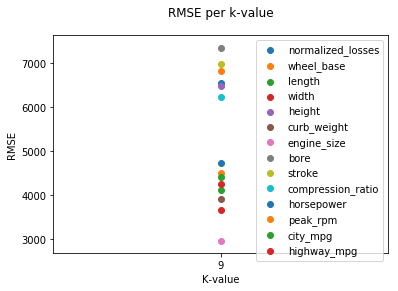

In [107]:
for k, v in k_rmse_result.items():
    x = list(v.keys())
    y = list(v.values())
    plt.scatter(x, y, label=k)
    plt.xlabel('K-value')
    plt.ylabel('RMSE')
    plt.xticks(x)
    plt.title('RMSE per k-value', y=1.06)
    plt.legend(bbox_to_anchor=(1, 1))

It appears that a k-value of 5 is the most optimal for the **Univariate model** because all the columns are closest when k=5.

## Multivariate Model

Now, I'll calculate the average RMSE accross different k values for each feature.

Then, I will modify the `knn_test_train()` function to work with multiple columns.

Then I'll use the modified function to calculate the RMSE when using the top 2, 3, 4, and 5 best features.

In [108]:
#Calculating the average RMSE across different `k` values for each feature.

avg_rmse = {}

for k, v in k_rmse_result.items():
    key = k
    value = np.mean(list(v.values()))
    avg_rmse[key] = value
    
avg_rmse_series = pd.Series(avg_rmse)
avg_rmse_series = avg_rmse_series.sort_values()
avg_rmse_series

engine_size          2951.586311
width                3665.167444
curb_weight          3914.818478
city_mpg             4114.050553
highway_mpg          4249.080450
length               4407.827048
wheel_base           4488.496411
horsepower           4717.573084
compression_ratio    6218.363073
height               6484.278955
normalized_losses    6534.518371
peak_rpm             6817.364517
stroke               6975.780622
bore                 7347.122882
dtype: float64

Modifying the `knn_test_train()` function to work with multiple columns.

In [109]:
def knn_train_test_list(train_col, target_col, df):
    knn = KNeighborsRegressor()
    np.random.seed(1)
    
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #Split the dataset in two:
    train_set = rand_df[:int(len(rand_df)*0.75)]
    test_set = rand_df[int(len(rand_df)*0.75):]
    
    knn.fit(train_set[train_col], train_set[target_col])
    predictions = knn.predict(test_set[train_col])
    
    #Calculate the RMSE
    mse = mean_squared_error(test_set[target_col], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

Now, let's use the 2, 3, 4, and 5 best features from the previous step with default k value of 5.

In [110]:
best_features = {}

for x in range(2,6):
    rmse = knn_train_test_list(avg_rmse_series.index[:x], 'price', cars)
    best_features['RMSE for Features: {}'.format(list(avg_rmse_series.index[:x]))] = rmse

In [111]:
best_features

{"RMSE for Features: ['engine_size', 'width']": 2638.287274194467,
 "RMSE for Features: ['engine_size', 'width', 'curb_weight']": 2202.6851914309086,
 "RMSE for Features: ['engine_size', 'width', 'curb_weight', 'city_mpg']": 2587.380871937989,
 "RMSE for Features: ['engine_size', 'width', 'curb_weight', 'city_mpg', 'highway_mpg']": 2622.863427630192}

So it looks like the **Multivariate model** preforms best with four features.

## Hyperparameter Tuning

Now I'll optimize the model that performed the best in the previous step.

For the top three models from the previous step, I will change the hyperparameter value from 1 to 25 and plot the resulting values.

In [112]:
def knn_train_test_k(train_col_list, target_col, df):
    np.random.seed(1)
    
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #Split the dataset in two:
    train_set = rand_df[:int(len(rand_df)*0.75)]
    test_set = rand_df[int(len(rand_df)*0.75):]
    
    k_values = range(1,26)
    k_rmses = {}
    
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors = k)
        knn.fit(train_set[train_col_list], train_set[target_col])
        predictions = knn.predict(test_set[train_col_list])
    
        #Calculate the RMSE
        mse = mean_squared_error(test_set[target_col], predictions)
        k_rmses[k] = np.sqrt(mse)
    return k_rmses

In [113]:
top3 = [3,4,5]

top3_rmse = {}

for x in top3:
    rmse = knn_train_test_k(avg_rmse_series.index[:x], 'price', cars)
    top3_rmse['Best {} features'.format(x)] = rmse
top3_rmse

{'Best 3 features': {1: 1906.5086404415877,
  2: 1963.0485557807635,
  3: 2103.638655941472,
  4: 2071.129648484936,
  5: 2202.6851914309086,
  6: 2220.9522819437216,
  7: 2359.478442073045,
  8: 2494.525497877066,
  9: 2608.1160640923035,
  10: 2673.756613133385,
  11: 2576.275116507519,
  12: 2611.4714022044336,
  13: 2728.209505590224,
  14: 2817.056136698544,
  15: 2917.0561041073247,
  16: 3037.62505630467,
  17: 3160.157808375733,
  18: 3251.1342464818053,
  19: 3325.3128630511487,
  20: 3356.7553394931374,
  21: 3460.788353015148,
  22: 3535.5115357007517,
  23: 3588.8164953840023,
  24: 3647.562909372811,
  25: 3710.698185483295},
 'Best 4 features': {1: 2199.4793234121676,
  2: 2228.2331521616306,
  3: 2391.5396532054474,
  4: 2454.423006603209,
  5: 2587.380871937989,
  6: 2648.1125135710513,
  7: 2664.826975832474,
  8: 2553.8646087745096,
  9: 2589.595922649844,
  10: 2665.743689192678,
  11: 2709.978270552664,
  12: 2739.444224779067,
  13: 2823.2535599492476,
  14: 2918.5

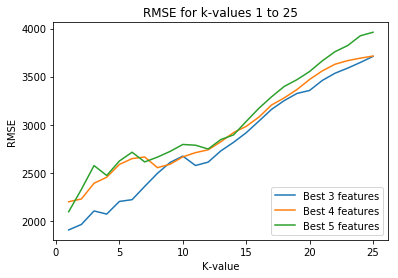

In [114]:
for k, v in top3_rmse.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x, y, label=k)
    plt.legend(loc='lower right')
    plt.xlabel('K-value')
    plt.ylabel('RMSE')
    plt.title('RMSE for k-values 1 to 25')

Seems like using a k-value 1 is best for the model when using the best 3, 4 and 5 features as it has the lowest RMSE values (~2000)

## K-fold cross validation

At this point, I'm going to modify the `knn_train_test()` function to use k-fold cross validation. I'll use the default n_neighbors of 5 and will loop through folds 2 to 10.

In [115]:
from sklearn.model_selection import KFold, cross_val_score

def knn_train_test_kfold(train_col, target_col, df, folds=range(2,12,2)):
    avg_rmses = {}
    
    for f in folds:
        kf = KFold(f, shuffle=True, random_state=1)
        knn = KNeighborsRegressor()
    
        mse = cross_val_score(knn, df[[train_col]], df[target_col], scoring='neg_mean_squared_error', cv=kf)
        rmse = np.sqrt(np.absolute(mse))
        avg_rmse = np.mean(rmse)
        avg_rmses[f] = avg_rmse

    return avg_rmses
diff_folds = {}

for col in numeric_cols[:-1]:
    diff_folds[col] = knn_train_test_kfold(col, 'price', cars, folds=range(2,12,2))
    
diff_folds_df = pd.DataFrame(diff_folds)
diff_folds_df

,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
2,7482.632289,5709.567683,5645.803155,4480.755962,7735.811797,4130.915690,3364.285473,6561.161516,7768.258096,6875.609561,3983.289877,7721.986452,4788.022045,4336.427993
4,6910.432610,5601.049008,5217.793716,4305.112854,7723.547222,4331.335448,3287.796580,6475.031311,7407.897334,6455.122963,3802.623017,7564.959829,4157.873935,4402.370669
6,7495.827796,5945.565378,5314.853031,4207.797327,7704.673968,3965.294847,3219.961874,6854.558582,7722.122646,6195.073611,3839.065975,7569.317860,4269.760675,4283.341086
8,6900.152199,5744.523778,5320.497538,4319.527199,7667.115403,4059.026943,3141.847651,6556.757544,7517.688928,6182.827390,3843.473451,7533.791225,4369.852715,4075.701847
10,6671.869661,5725.179143,5344.389417,4209.420018,7702.821601,4234.188078,3043.502927,6914.254048,7297.139641,6082.597131,3801.849871,7510.544452,4305.536968,4180.874800


We see that for 6 out of the 14 columns (~43%), 10 folds give the best result. Because of that, I will use 10 folds for the rest of the tests.

## Varying nearest neighbours

Now let's modify the `knn_train_test_kfold()` so that the k nearest neighbors changes - 1, 3, 5, 7, 9.

In [116]:
def knn_train_test_kfold(train_col, target_col, df, folds=10):
    avg_rmses = {}
    kf = KFold(folds, shuffle=True, random_state=1)
    k_values = range(1,10,2)
    
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        mse = cross_val_score(knn, df[[train_col]], df[target_col], scoring='neg_mean_squared_error', cv=kf)
        rmse = np.sqrt(np.absolute(mse))
        avg_rmse = np.mean(rmse)
        avg_rmses[k] = avg_rmse
    
    return avg_rmses
    
cols_k = {}

for col in numeric_cols[:-1]:
    cols_k[col] = knn_train_test_kfold(col, 'price', cars, folds=10)
    
cols_k_df=pd.DataFrame(cols_k)

cols_k_df

,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
1,7579.057448,4127.664023,4898.478019,4066.868124,8392.337279,5157.859842,3601.796747,8057.920723,8225.659301,6741.420713,3991.682326,8725.320610,5756.990928,5108.460253
3,7148.990331,4791.446221,5055.359831,4014.256862,7867.419571,4495.974906,3054.441896,6514.966390,7273.057903,5821.947865,3860.005144,7721.733869,4388.057423,4648.040609
5,6671.869661,5725.179143,5344.389417,4209.420018,7702.821601,4234.188078,3043.502927,6914.254048,7297.139641,6082.597131,3801.849871,7510.544452,4305.536968,4180.874800
7,7076.278964,5949.354619,5407.596946,4362.409681,7663.933333,4065.269237,3346.551409,6940.746752,7332.833386,6251.986521,3799.826781,7487.471490,4247.140019,4136.835757
9,7376.047238,5847.402960,5461.100326,4316.124588,7491.422748,3961.532240,3496.675613,6752.362175,7299.626100,6330.739278,3843.219943,7564.611083,4414.995561,4168.970779


Now, I'll use the above results for `k-values` [1,3,5,9] and average the results for each feature. I'll then use the top features to calculate the RMSE for more than one column over 10 folds.

In [117]:
#Calculate the average RMSE across different `k` values for each feature.

avg_rmse_k = {}

for k, v in cols_k.items():
    key = k
    value = np.mean(list(v.values()))
    avg_rmse_k[key] = value
    
avg_rmse_k_series = pd.Series(avg_rmse_k)
avg_rmse_k_series = avg_rmse_k_series.sort_values()
avg_rmse_k_series

engine_size          3308.593718
horsepower           3859.316813
width                4193.815855
curb_weight          4382.964861
highway_mpg          4448.636439
city_mpg             4622.544180
length               5233.384908
wheel_base           5288.209393
compression_ratio    6245.738302
bore                 7036.050018
normalized_losses    7170.448729
stroke               7485.663266
peak_rpm             7801.936301
height               7823.586906
dtype: float64

In [118]:
def knn_train_test_kfold(train_col, target_col, df, folds=10):
    kf = KFold(folds, shuffle=True, random_state=1)
    knn = KNeighborsRegressor()
    
    mse = cross_val_score(knn, df[train_col], df[target_col], scoring='neg_mean_squared_error', cv=kf)
    rmse = np.sqrt(np.absolute(mse))
    avg_rmse = np.mean(rmse)
    return avg_rmse
features = {}

for x in range(2,7):
    result = knn_train_test_kfold(list(avg_rmse_k_series.index[:x]), 'price', cars, folds=10)
    features["{} best features".format(x)] = result
    
features

{'2 best features': 2808.4983984193304,
 '3 best features': 3031.767371260333,
 '4 best features': 3010.436378520319,
 '5 best features': 3031.8000284536897,
 '6 best features': 3097.0129847108556}

Looks like the 10-fold model and k-value of 5 preforms best with 2 features.

I'll use the top 3 features combinations from above (2, 3, 4, 5) and calculate the RMSE with varying nearest neighbors from 1 to 25, using 10 folds.

In [121]:
def knn_train_test_kfold(train_col, target_col, df, folds=10):
    kf = KFold(folds, shuffle=True, random_state=1)
    
    avg_rmses = {}
    for k in range(1,26):
        knn = KNeighborsRegressor(n_neighbors=k)
    
        mse = cross_val_score(knn, df[train_col], df[target_col], scoring='neg_mean_squared_error', cv=kf)
        rmse = np.sqrt(np.absolute(mse))
        avg_rmse = np.mean(rmse)
        avg_rmses[k] = avg_rmse
    return avg_rmses

In [123]:
features_25 = {}

features = [2,3,4,5]

for x in features:
    result = knn_train_test_kfold(list(avg_rmse_k_series.index[:x]), 'price', cars, folds=10)
    features_25["{} best features".format(x)] = result
    
features_25

{'2 best features': {1: 2844.6738023575053,
  2: 2601.2320598273477,
  3: 2636.5883949955796,
  4: 2787.516162198912,
  5: 2808.4983984193304,
  6: 2845.3008673634185,
  7: 2934.275309828578,
  8: 3137.167365122338,
  9: 3205.8876254263178,
  10: 3285.3850135510047,
  11: 3422.1375743796843,
  12: 3550.5516722965376,
  13: 3691.4335807073912,
  14: 3793.5952330652267,
  15: 3868.994116314313,
  16: 3897.4576330716213,
  17: 3933.2465918697517,
  18: 4025.3490798025623,
  19: 4085.6682300076645,
  20: 4140.402487825685,
  21: 4166.786411146952,
  22: 4205.597041611041,
  23: 4278.854191048603,
  24: 4336.7415031100345,
  25: 4396.694250351881},
 '3 best features': {1: 2726.9297759497135,
  2: 2703.564030002367,
  3: 2781.5659507487435,
  4: 2919.9368436139735,
  5: 3031.767371260333,
  6: 3163.352228814234,
  7: 3301.7360046271315,
  8: 3334.8298982284878,
  9: 3363.2517083798375,
  10: 3386.824559906182,
  11: 3411.1854293862043,
  12: 3427.6208376397676,
  13: 3509.0328877950074,
  14

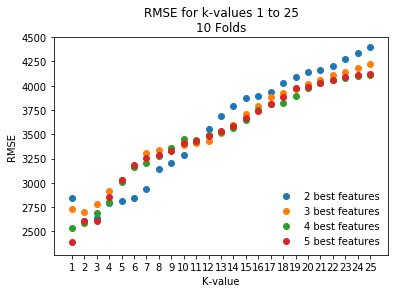

In [137]:
for k, v in features_25.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.scatter(x, y, label=k)
    plt.legend(loc='lower right', frameon=False)
    plt.xticks(x)
    plt.xlabel('K-value')
    plt.ylabel('RMSE')
    plt.title('RMSE for k-values 1 to 25\n10 Folds')

It looks like 3, 4, and 5 best features produce most accurate results with k value of 2 whereas 5 features work best with k value of 1.

## Conclusion
The **5 best features** produced the most accurate results for predicting price values when the **k value is 1**